In [9]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm
from tqdm import tqdm_notebook as tqdm
from sklearn.linear_model import LogisticRegression # must come before nest
%matplotlib inline

In [10]:
plt.rcParams['figure.figsize'] = (12,9)
plt.rcParams.update({
    k: 'xx-large' for k in plt.rcParams 
    if (
        k.endswith('labelsize') or
        k.endswith('fontsize')
    )
})

In [34]:
def prune(a, ref):
    b = np.concatenate(([False], np.diff(a) < ref))
    c = np.concatenate(([False], np.diff(b.astype(int)) > 0))
    d = a[~c]
    if any(np.diff(a) < ref):
        d = prune(d, ref)
    return d


def generate_stim_times(stim_rate, stim_isi_min, stop_time):
    stim_times = np.sort(np.random.uniform(
        0, stop_time, stim_rate * stop_time))
    return prune(stim_times, stim_isi_min)


def generate_neurons(stim_times, make_post=False, **p):
    n_stim = len(stim_times)
    idxs = np.random.permutation(np.arange(n_stim).astype(int))
    n_stim_spikes = int(n_stim * p['stim_hit_chance'])
    idxs_stim_spikes = idxs[:n_stim_spikes]

    spikes = np.sort(np.concatenate([
        stim_times[idxs_stim_spikes] + p['stim_latency'],
        np.random.uniform(0, p['stop_time'], p['pre_rate'] * p['stop_time'])
    ]))
    pre_spikes = prune(spikes, p['refractory'])
    n_pre_spikes = len(pre_spikes)
    if make_post:
        n_post_spikes = int(n_pre_spikes * p['pre_hit_chance'])
        idxs_post_spikes = np.random.permutation(np.arange(n_pre_spikes).astype(int))[:n_post_spikes]

        post_spikes = np.sort(np.concatenate([
            pre_spikes[idxs_post_spikes] + p['latency'],
            np.random.uniform(0, p['stop_time'], int(p['post_rate'] * p['stop_time']))
        ]))
        post_spikes = prune(post_spikes, p['refractory'])
    
        return pre_spikes, post_spikes
    else:
        return pre_spikes

In [37]:
def raised_cosine(n_bases, bin_size, end_peak_times, offset, stretching='log'):
    '''Raised cosine basis
      ^
     / \
    /   \______
         ^
        / \
    ___/   \___
            ^
           / \
    ______/   \
    Make log or linearly stretched basis consisting of raised cosines.
    Log stretching allows faster changes near the event. Adapted from _[1]
    
    Parameters
    ----------
    n_bases : int
        Number of basis vectors
    bin_size : float
        time bin size (separation for representing basis
    end_peak_times : array
        [2 x 1] array containg [1st_peak,  last_peak], the peak
             (i.e. center) of the first and the last raised cosine basis vectors
    offset: float
        offset for log stretching of x axis:  y = log(t + offset)
        (larger offset -> more nearly linear stretching)
    stretching : str
        "log" or "linear"

    Returns
    -------
    time : array
        time lattice on which basis is defined
    bases : array
        basis itself
    centers : array
        centers of each basis function

    Example
    -------
    time, bases, centers = log_raised_cosine(10, 1, [0, 500], 2);
    
    References
    ----------
    _[1] : Pillow 2008
    '''
    if stretching == 'log':
        if offset <= 0:
            raise ValueError('offset must be greater than 0')
        #log stretching x axis (and its inverse)
        stretch = lambda x: np.log(x + 1e-20)
        inv_stretch = lambda x: np.exp(x) - 1e-20
    elif stretching == 'linear':
        stretch = lambda x: x
        inv_stretch = lambda x: x
        offset = 0
    else:
        raise ValueError('stretching must be "log" or "linear"')
    
    x_range = stretch(end_peak_times + offset)

    db = np.diff(x_range) / (n_bases - 1)  # spacing between raised cosine peaks

    centers = np.arange(x_range[0], x_range[1] + db / 2, db)  # centers for basis vectors

    max_time_bin = inv_stretch(x_range[1] + db) - offset  # maximum time bin (originally 2 * db)

    time = np.arange(0, max_time_bin, bin_size)
    
    centers_tiled = np.tile(centers, (time.size, 1))

    time_stretch_tiled = np.tile(stretch(time + offset)[:, np.newaxis], (1, n_bases))

    def _raised_cosine(time, centers, dc):
        center_adjusted = (time - centers) * np.pi / dc # originally divided by 2
        center_adjusted_min = np.minimum(np.pi, center_adjusted)
        center_adjusted_min_max = np.maximum(-np.pi, center_adjusted_min)
        return (np.cos(center_adjusted_min_max) + 1) / 2

    bases = _raised_cosine(time_stretch_tiled, centers_tiled, db)

    centers = inv_stretch(centers)

    return time, bases, centers

In [35]:
# def OLS(X, y):
#     dot, inv = np.dot, np.linalg.inv
#     return dot(dot(inv(dot(X.T, X)), X.T), y)


# def calculate_regressors(x, y, stim_times, winsize):
#     stim_times = stim_times.astype(float)
    
#     src_x = np.searchsorted(x, stim_times, side='right')
    
#     remove_idxs, = np.where((src_x==len(x)) | (src_x==0))
#     src_x = np.delete(src_x, remove_idxs)
#     stim_times = np.delete(stim_times, remove_idxs)
#     Z = x[src_x-1] - stim_times
#     X = x[src_x] - stim_times
    
#     stim_win = np.insert(stim_times, np.arange(len(stim_times)) + 1, stim_times + winsize)
#     src_y = np.searchsorted(y, stim_win, side='left')
#     cnt_y = np.diff(src_y.reshape((int(len(src_y) / 2), 2)))
#     Y = cnt_y.flatten()
#     return Z, X, Y


# def IV(x, y, stim_times, winsize):
            
#     Z, X, Y = calculate_regressors(x, y, stim_times, winsize)
    
#     Z = np.vstack((np.ones(Z.shape[0]), Z))
#     W = OLS(Z.T, X)
#     X_fittedvalues = np.dot(W, Z)
#     plt.plot(X_fittedvalues[:500])
#     XX = np.array([np.ones(X_fittedvalues.shape[0]), X_fittedvalues])

#     _, beta_IV = OLS(XX.T, Y.astype(float))
    
#     return beta_IV

# def IV(x, y, stim_times, winsize): # OLS
            
#     Z, X, Y = calculate_regressors(x, y, stim_times, winsize)
    
#     Z = np.vstack((Z, np.ones(Z.shape[0]))).T
    
#     X = np.vstack((X, np.ones(X.shape[0]))).T
    
#     W = OLS(Z, X)
    
#     X_hat = np.dot(Z, W)
    
#     beta_IV, _ = OLS(X_hat, Y)
    
#     return beta_IV

def calculate_regressors(x, y, stim_times, y_mu, y_sigma):
    stim_times = stim_times.astype(float)
    
    src_x = np.searchsorted(x, stim_times, side='right')
    
    remove_idxs, = np.where((src_x==len(x)) | (src_x==0))
    src_x = np.delete(src_x, remove_idxs)
    stim_times = np.delete(stim_times, remove_idxs)
    Z = x[src_x-1] - stim_times
    X = x[src_x] - stim_times
    
    stim_win = np.insert(
        stim_times + y_mu - y_sigma, 
        np.arange(len(stim_times)) + 1, 
        stim_times + y_mu + y_sigma)
    src_y = np.searchsorted(y, stim_win, side='left')
    cnt_y = np.diff(src_y.reshape((int(len(src_y) / 2), 2)))
    Y = cnt_y.flatten()
    return Z, X, Y


def IV(x, y, stim_times, x_mu, x_sigma, y_mu, y_sigma, n_bases=20, bin_size=1e-3, offset=1e-2):
            
    Z, X, Y = calculate_regressors(x, y, stim_times, y_mu, y_sigma)
    
    X = ((X > x_mu - x_sigma) & (X < x_mu + x_sigma)).astype(int)
    Z = np.abs(Z)
    max_time = Z.max()
    
    time, bases, centers = raised_cosine(n_bases, bin_size, np.array([0, max_time]), offset)
    Z_bases = np.zeros((len(Z), n_bases))

    def index(t, bin_size):
        return np.ceil(t / bin_size).astype(int)

    idxs = index(Z, bin_size)
    Z_bases[:, :] = bases[idxs, :]
    

    model = LogisticRegression(C=1e5, solver='liblinear')
    model.fit(Z_bases, X)
    X_hat = model.predict(Z_bases)
    
    X_hat = np.vstack((X_hat, np.ones(X_hat.shape[0]))).T
    beta_IV, _ = np.linalg.lstsq(X_hat, Y, rcond=None)[0]
    
    return beta_IV

In [59]:
stim_params = {
    'stop_time': 2000, # seconds
    'stim_rate': 30, # rate of stimulation (gets reduced by pruning for minimum inter stimulus interval)
    'stim_isi_min': 30e-3, # minimum inter stimulus interval
}
neuron_params = {
    'refractory': 4e-3, # 4 ms
    'latency': 4e-3, # post response delay
#         'latency_std': 1e-3,
    'pre_hit_chance': .8, # fraction of spikes that are driven by the presynaptic neuron
    'post_rate': 5, # Hz
    'pre_rate': 5, # base rate
    'stim_hit_chance': .8, # fraction of spikes that are driven by the stimulation
    'stim_latency': 2e-3, # latency from stim to pre response
#         'stim_latency_std': .5e-3,
    'stop_time': stim_params['stop_time'],
}
iv_params = {
    'x_mu': 2e-3,
    'x_sigma': .1e-3,
    'y_mu': 6e-3,
    'y_sigma': .1e-3,
    'n_bases': 10,
    'bin_size': 1e-3,
    'offset': 1e-2
}

stim_times = generate_stim_times(**stim_params) 

A_spikes, C_spikes = generate_neurons(stim_times, make_post=True, **neuron_params)

B_spikes = generate_neurons(stim_times, make_post=False, **neuron_params)

beta_AC = IV(
    x=A_spikes, y=C_spikes, stim_times=stim_times, **iv_params)

beta_BC = IV(
    x=B_spikes, y=C_spikes, stim_times=stim_times, **iv_params)

beta_AC, beta_BC

(0.4392144583672284, 0.01962347587153943)

# Increasing hit chance A -> C

In [60]:
results = []
for h in tqdm(np.arange(0, 1.1, .1)):
    stim_params = {
        'stop_time': 2000, # seconds
        'stim_rate': 30, # rate of stimulation (gets reduced by pruning for minimum inter stimulus interval)
        'stim_isi_min': 30e-3, # minimum inter stimulus interval
    }
    neuron_params = {
        'refractory': 4e-3, # 4 ms
        'latency': 4e-3, # post response delay
#         'latency_std': 1e-3,
        'pre_hit_chance': h, # fraction of spikes that are driven by the presynaptic neuron
        'post_rate': 5, # Hz
        'pre_rate': 5, # base rate
        'stim_hit_chance': .8, # fraction of spikes that are driven by the stimulation
        'stim_latency': 2e-3, # latency from stim to pre response
#         'stim_latency_std': .5e-3,
        'stop_time': stim_params['stop_time'],
    }
    iv_params = {
        'x_mu': 2e-3,
        'x_sigma': 1e-3,
        'y_mu': 6e-3,
        'y_sigma': 1e-3,
        'n_bases': 10,
        'bin_size': 1e-3,
        'offset': 1e-2
    }
    
    stim_times = generate_stim_times(**stim_params) 
    
    A_spikes, C_spikes = generate_neurons(stim_times, make_post=True, **neuron_params)

    B_spikes = generate_neurons(stim_times, make_post=False, **neuron_params)

    beta_AC = IV(
        x=A_spikes, y=C_spikes, stim_times=stim_times, **iv_params)
    
    beta_BC = IV(
        x=B_spikes, y=C_spikes, stim_times=stim_times, **iv_params)
    
    res = {
        'A_rate': len(A_spikes) / neuron_params['stop_time'], 
        'B_rate': len(B_spikes) / neuron_params['stop_time'], 
        'C_rate': len(C_spikes) / neuron_params['stop_time'],
        'S_rate': len(stim_times) / neuron_params['stop_time'],
        'C_induced_rate': (len(C_spikes) / neuron_params['stop_time']) - neuron_params['post_rate'],
        'beta_AC': beta_AC,
        'beta_BC': beta_BC
    }
    results.append({**stim_params, **neuron_params, **iv_params, **res})
    
results = pd.DataFrame(results)
results

HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

,A_rate,B_rate,C_induced_rate,C_rate,S_rate,beta_AC,beta_BC,bin_size,latency,n_bases,...,refractory,stim_hit_chance,stim_isi_min,stim_latency,stim_rate,stop_time,x_mu,x_sigma,y_mu,y_sigma
0,17.0520,17.0680,-0.1030,4.8970,15.8155,-0.005174,0.007564,0.001,0.004,10,...,0.004,0.8,0.03,0.002,30,2000,0.002,0.001,0.006,0.001
1,17.0065,17.0175,1.5380,6.5380,15.7710,0.080771,-0.014527,0.001,0.004,10,...,0.004,0.8,0.03,0.002,30,2000,0.002,0.001,0.006,0.001
2,17.0415,17.0375,3.1745,8.1745,15.7870,0.094299,0.001001,0.001,0.004,10,...,0.004,0.8,0.03,0.002,30,2000,0.002,0.001,0.006,0.001
3,17.0450,17.0235,4.8055,9.8055,15.7660,0.159421,0.021165,0.001,0.004,10,...,0.004,0.8,0.03,0.002,30,2000,0.002,0.001,0.006,0.001
4,17.0270,17.0390,6.4660,11.4660,15.7805,0.224064,-0.003370,0.001,0.004,10,...,0.004,0.8,0.03,0.002,30,2000,0.002,0.001,0.006,0.001
5,16.9930,17.0345,8.0760,13.0760,15.7660,0.266250,0.033634,0.001,0.004,10,...,0.004,0.8,0.03,0.002,30,2000,0.002,0.001,0.006,0.001
6,16.9475,16.9960,9.6980,14.6980,15.7530,0.321549,-0.024374,0.001,0.004,10,...,0.004,0.8,0.03,0.002,30,2000,0.002,0.001,0.006,0.001
7,17.0715,17.0445,11.4000,16.4000,15.8095,0.359118,-0.005535,0.001,0.004,10,...,0.004,0.8,0.03,0.002,30,2000,0.002,0.001,0.006,0.001
8,17.0405,17.0280,13.0080,18.0080,15.7860,0.628200,-0.003550,0.001,0.004,10,...,0.004,0.8,0.03,0.002,30,2000,0.002,0.001,0.006,0.001
9,17.0410,17.0750,14.6595,19.6595,15.8160,0.497447,-0.014491,0.001,0.004,10,...,0.004,0.8,0.03,0.002,30,2000,0.002,0.001,0.006,0.001


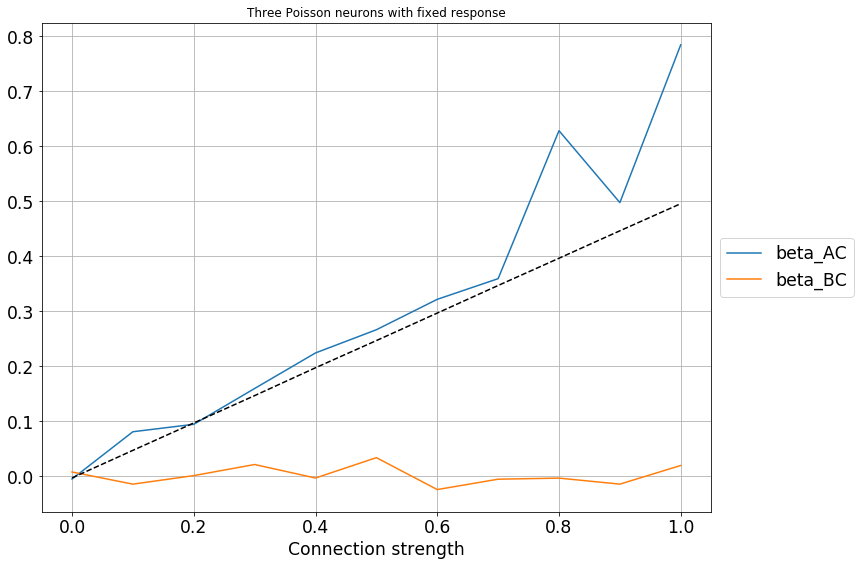

In [62]:
keys = [
#     'A_rate',
#     'B_rate',
#     'C_rate',
#     'S_rate',
    'beta_AC',
    'beta_BC',
#     'C_induced_rate'
]

cmap = cm.get_cmap('tab10')
cnt = 0
for key in keys:
    plt.plot(results['pre_hit_chance'], results[key], label=key, color=cmap(cnt))
    cnt += 1
plt.grid(True)

plt.plot(results['pre_hit_chance'], results.C_induced_rate / (results.A_rate + results.S_rate), '--k')

plt.title('Three Poisson neurons with fixed response')
plt.xlabel('Connection strength')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Increasing stop time

In [27]:
results = []
for h in tqdm(np.arange(100, 6100, 10)):
    stim_params = {
        'stop_time': h, # seconds
        'stim_rate': 30, # rate of stimulation (gets reduced by pruning for minimum inter stimulus interval)
        'stim_isi_min': 50e-3, # minimum inter stimulus interval
    }
    neuron_params = {
        'refractory': 4e-3, # 4 ms
        'latency': 6e-3, # post response delay
        'pre_hit_chance': .5, # fraction of spikes that are driven by the presynaptic neuron
        'post_rate': 5, # Hz
        'pre_rate': 5, # base rate
        'stim_hit_chance': .8, # fraction of spikes that are driven by the stimulation
        'stim_latency': 5e-4, # latency from stim to pre response
        'stop_time': stim_params['stop_time'],
    }
    iv_params = {
        'winsize': 8e-3
    }
    
    stim_times = generate_stim_times(**stim_params) 
    
    A_spikes, C_spikes = generate_neurons(stim_times, make_post=True, **neuron_params)

    B_spikes = generate_neurons(stim_times, make_post=False, **neuron_params)

    beta_AC = IV(
        x=A_spikes, y=C_spikes, stim_times=stim_times, **iv_params)
    
    beta_BC = IV(
        x=B_spikes, y=C_spikes, stim_times=stim_times, **iv_params)
    
    res = {
        'A_rate': len(A_spikes) / neuron_params['stop_time'], 
        'B_rate': len(B_spikes) / neuron_params['stop_time'], 
        'C_rate': len(C_spikes) / neuron_params['stop_time'],
        'S_rate': len(stim_times) / neuron_params['stop_time'],
        'C_induced_rate': (len(C_spikes) / neuron_params['stop_time']) - neuron_params['post_rate'],
        'beta_AC': beta_AC,
        'beta_BC': beta_BC
    }
    results.append({**stim_params, **neuron_params, **iv_params, **res})
    
results = pd.DataFrame(results)
results.head()

HBox(children=(IntProgress(value=0, max=600), HTML(value='')))

,A_rate,B_rate,C_induced_rate,C_rate,S_rate,beta_AC,beta_BC,latency,post_rate,pre_hit_chance,pre_rate,refractory,stim_hit_chance,stim_isi_min,stim_latency,stim_rate,stop_time,winsize
0,14.140000,14.090000,6.690000,11.690000,12.100000,9.374244,10.913132,0.006,5,0.5,5,0.004,0.8,0.05,0.0005,30,100,0.008
1,14.181818,14.354545,6.627273,11.627273,12.190909,6.865382,1.072448,0.006,5,0.5,5,0.004,0.8,0.05,0.0005,30,110,0.008
2,14.091667,14.183333,6.658333,11.658333,12.083333,1.830445,-4.895754,0.006,5,0.5,5,0.004,0.8,0.05,0.0005,30,120,0.008
3,14.215385,14.200000,6.876923,11.876923,11.992308,17.225966,16.000537,0.006,5,0.5,5,0.004,0.8,0.05,0.0005,30,130,0.008
4,14.042857,14.121429,6.564286,11.564286,11.964286,20.628337,18.072406,0.006,5,0.5,5,0.004,0.8,0.05,0.0005,30,140,0.008
5,14.093333,14.193333,6.653333,11.653333,12.020000,-6.187352,2.564717,0.006,5,0.5,5,0.004,0.8,0.05,0.0005,30,150,0.008
6,14.112500,14.187500,6.718750,11.718750,12.031250,2.361970,-11.751113,0.006,5,0.5,5,0.004,0.8,0.05,0.0005,30,160,0.008
7,14.170588,14.200000,6.700000,11.700000,12.076471,9.828869,-2.801731,0.006,5,0.5,5,0.004,0.8,0.05,0.0005,30,170,0.008
8,14.205556,14.122222,6.777778,11.777778,11.983333,27.150225,-0.006820,0.006,5,0.5,5,0.004,0.8,0.05,0.0005,30,180,0.008
9,14.184211,14.105263,6.742105,11.742105,12.005263,-0.283364,4.630576,0.006,5,0.5,5,0.004,0.8,0.05,0.0005,30,190,0.008


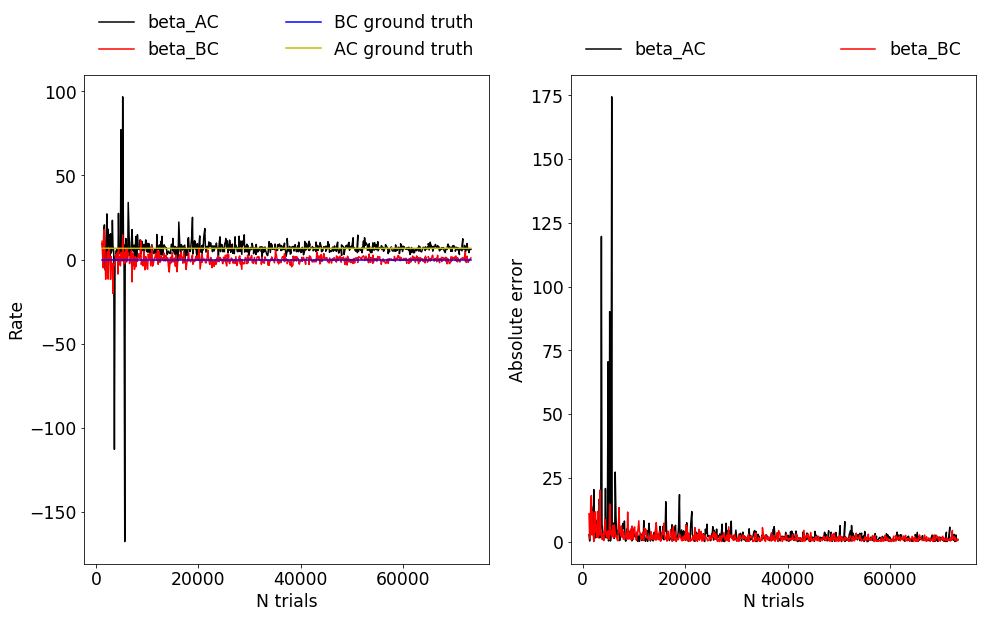

In [45]:
fig, (ax_v, ax_e) = plt.subplots(1, 2, figsize=(16, 9))

ax_v.plot(
    results['stop_time'] * results['S_rate'], 
    results['beta_AC'], 
    color='k')

ax_v.plot(
    results['stop_time'] * results['S_rate'], 
    results['beta_BC'], 
    color='r')

ax_v.plot(
    results['stop_time'] * results['S_rate'], 
    np.zeros(len(results['stop_time'])), 
    label='BC ground truth', color='b')

ax_v.plot(
    results['stop_time'] * results['S_rate'], 
    results['C_induced_rate'], 
    label='AC ground truth', color='y')

ax_e.plot(
    results['stop_time'] * results['S_rate'], 
    abs(results['beta_AC'] - results['C_induced_rate']), 
    label='beta_AC', color='k')

ax_e.plot(
    results['stop_time'] * results['S_rate'], 
    abs(results['beta_BC'] - 0), 
    label='beta_BC', color='r')

ax_v.set_xlabel('N trials')
ax_e.set_xlabel('N trials')
ax_e.set_ylabel('Absolute error')
ax_v.set_ylabel('Rate')

ax_v.legend(
    bbox_to_anchor=(0., 1.00, 1., .102), loc=3,
    ncol=2, mode="expand", frameon=False)

ax_e.legend(
    bbox_to_anchor=(0., 1.00, 1., .102), loc=3,
    ncol=2, mode="expand", frameon=False)